# 882 Replication with SOEP Data

- Data from SOEP, 2017
- Estimation strategy from Flabbi 2010 

## Import Packages

In [95]:
# Data Manipulation 
import numpy as np
import pandas as pd
from winsorize import winsorize_column

# General
import pdb

# Estimation
from scipy.optimize import minimize
import scipy.stats as stats
# import numdifftools as ndt
import scipy.integrate as integrate

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn.apionly as sns
from pylab import *

## Import Data 

- SOEP (Germany) data on gender, wages, duration of unemployment
- M: males
- F: females
- U: unemployed
- E: employed 
- {M,F} X {E,U} = {males,females} X {employed, unemployed}

In [2]:
df=pd.read_stata('../data/merged.dta') # 624,562
df.columns = ['pid', 'year', 'inc_gro', 'inc_net', 'pos', 'emplsta', 'change', 'change_reason', 'dur', 'sex', 'age', 'hours', 'edu']

# Only the year 2017
df1 = df[df['year']==2017] # 31,630

# Turning categorical into dummies
df_sex = pd.get_dummies(df1, columns=['sex'])
# 1 if man, 2 if woman. 
df_empl = pd.get_dummies(df_sex, columns=['emplsta'])
# 5 if unemployed, 1 if full time
df_edu = pd.get_dummies(df_empl, columns=['edu'])
# 6 if bachelors, 7 if masters, 8 if doctorate

# Keeping only the necessary variables 
df2 = df_edu[['inc_net', 'dur', 'age', 'sex_[2] weiblich', 'emplsta_[1] Voll erwerbstaetig', 'emplsta_[5] Nicht erwerbstaetig', 'hours', 'edu_[6] Bachelor s or equivalent level', 'edu_[7] Master s or equivalent level', 'edu_[8] Doctoral or equivalent level']]
df2.columns = ['wage', 'dur', 'age', 'women', 'ft_empl', 'unempl', 'hours', 'college', 'masters', 'phd']

# Using age for condition, then dropping age as a variable
AGE_LOW = (df2['age']>29)
AGE_HIGH = (df2['age']<56)
AGE_COND = AGE_LOW & AGE_HIGH

df3 = df2[AGE_COND==True] # 15,443

# Creating condition for FT employment or unemployed only 
FT_COND = (df3['ft_empl']==1)
UN_COND = (df3['unempl']==1)
EMPL_COND = FT_COND | UN_COND

df4 = df3[EMPL_COND==True] # 11,533

# Ensuring positive hours, wages for employed; positive unemployment duration for unemployed
POS_WAGE = (df4['wage']>0)
POS_HOURS = (df4['hours']>0)
EMPL = (df4['ft_empl']==1)
EMPLVAR_COND = POS_WAGE & POS_HOURS & EMPL

POS_DUR = (df4['dur']>0)
UNEMPL = (df4['unempl']==1)
UNEMPLVAR_COND = POS_DUR & UNEMPL

CONSIST_COND = EMPLVAR_COND | UNEMPLVAR_COND

df5 = df4[CONSIST_COND==True] #8,439

# Keeping only college or more educated 
BS_COND = (df5['college']==1) 
MS_COND = (df5['masters']==1) 
PHD_COND = (df5['phd']==1)
EDU_COND = BS_COND | MS_COND | PHD_COND

df6= df5[EDU_COND==True] #2,226

# Change wage to be hourly 
df6['wage'] = df6['wage'] / (df6['hours']*4)

# Dropping unnecessary columns (age, unempl, edu, hours) and reorganizing to be consistent with CPS organization
df7 = df6[['dur', 'wage', 'ft_empl', 'women']]
df7.columns = ['dur', 'wage', 'empl', 'women']

/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Note: Missing data (no answer/does not apply) are denoted by negative values by the SOEP. Instead of coding these negative values to zero, they are kept. The inclusion criteria below ensure that there are positive wage and hours for the employed, and positive duration values for the unemployed. In the following analysis, the data is broken into employment status and gender, so the negatives do not affect the descriptive statistics or empirics. This methodology was chosen so not to add unneccessary complications and/or impact the data that we wish to study. 

In [3]:
df7.describe()

,dur,wage,empl,women
count,2226.000000,2226.000000,2226.000000,2226.000000
mean,0.610153,15.909179,0.813118,0.384996
std,1.467214,11.063978,0.389905,0.486704
min,-1.000000,0.250000,0.000000,0.000000
25%,0.000000,9.459459,1.000000,0.000000
50%,0.000000,15.745370,1.000000,0.000000
75%,0.600000,22.135989,1.000000,1.000000
max,15.000000,125.000000,1.000000,1.000000


In [4]:
# Creating naming conventions that are consistent with analysis from CPS data

data = df7 

M = data[data['women']==0] # 1369 men 
F = data[data['women']==1] # 857 women 
U = data[data['empl']==0] # 416 unemployed
E = data[data['empl']==1] # 1810 employed

ME = M[M['empl']==1] # 1147 employed men
MU = M[M['empl']==0] # 222 unemployed men
FE = F[F['empl']==1] # 663 employed women
FU = F[F['empl']==0] # 194 unemployed women

### Summary Statistics, without trimming

In [5]:
agg_dict = {
    'wage': ['mean', 'std', 'count'],
    'dur': ['mean', 'std', 'count'],
}

In [6]:
print(data.groupby(['women', 'empl']).agg(agg_dict).to_latex()) # by gender

\begin{tabular}{llrrrrrr}
\toprule
  &   & \multicolumn{3}{l}{wage} & \multicolumn{3}{l}{dur} \\
  &   &       mean &       std & count &      mean &       std & count \\
women & empl &            &           &       &           &           &       \\
\midrule
0 & 0 &   0.250000 &  0.000000 &   222 &  1.791892 &  2.090709 &   222 \\
  & 1 &  21.065335 &  9.464534 &  1147 &  0.274194 &  0.815939 &  1147 \\
1 & 0 &   0.250000 &  0.000000 &   194 &  2.184021 &  2.801259 &   194 \\
  & 1 &  16.814318 &  7.442181 &   663 &  0.335143 &  0.932893 &   663 \\
\bottomrule
\end{tabular}



In [7]:
print(data.groupby(['empl']).agg(agg_dict).to_latex()) # all

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{wage} & \multicolumn{3}{l}{dur} \\
{} &       mean &       std & count &      mean &       std & count \\
empl &            &           &       &           &           &       \\
\midrule
0    &   0.250000 &  0.000000 &   416 &  1.974760 &  2.452638 &   416 \\
1    &  19.508195 &  9.011808 &  1810 &  0.296519 &  0.860871 &  1810 \\
\bottomrule
\end{tabular}



/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


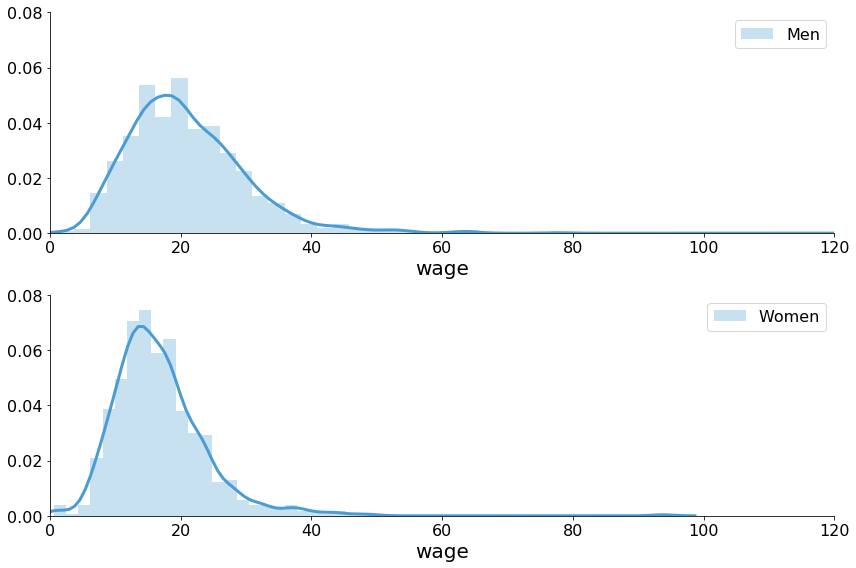

In [8]:
# Seaborn
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.distplot(ME['wage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=50, ax=ax[0])
sns.distplot(FE['wage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=50, ax=ax[1])

ax[0].legend(['Men'])
ax[1].legend(['Women']) 

ax[0].set_xlim([0,120])
ax[1].set_xlim([0,120])

ax[0].set_ylim([0,0.08])
ax[1].set_ylim([0,0.08])

plt.tight_layout()

In [9]:
fig.savefig('./figures/fig1_2_SOEP_raw.png', bbox_inches='tight', transparent=True)

### Summary Statistics, with winsorizing of wages

In [10]:
minwage_2017 = 8.84

#### Winsorizing for Men

In [11]:
# Establish Tukeys Fences, Men
q1M = percentile(ME['wage'], 25)
q3M = percentile(ME['wage'], 75)
iqrM = q3M - q1M

lower_limitM = q1M - 1.5 * iqrM
upper_limitM = q3M + 1.5 * iqrM

In [98]:
lower_limitM

-1.2414668935612632

In [12]:
# # Winsorizing at the lower and upper limit defined by Tukey's fences
# ME.loc[ME['wage'] < lower_limitM, 'wage'] = lower_limitM
# ME.loc[ME['wage'] > upper_limitM, 'wage'] = upper_limitM

# Winsorizing the lower at the minimum wage, the upper defined by Tukey's fences
ME.loc[ME['wage'] < minwage_2017, 'wage'] = minwage_2017
ME.loc[ME['wage'] > upper_limitM, 'wage'] = upper_limitM

/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
ME.describe()

,dur,wage,empl,women
count,1147.000000,1147.000000,1147.0,1147.0
mean,0.274194,20.826208,1.0,0.0
std,0.815943,8.062265,0.0,0.0
min,-1.000000,8.840000,1.0,0.0
25%,0.000000,14.909115,1.0,0.0
50%,0.000000,19.512195,1.0,0.0
75%,0.000000,25.676170,1.0,0.0
max,8.100000,41.826751,1.0,0.0


#### Winsorizing for Women

In [14]:
# Establish Tukeys Fences, Women
q1F = percentile(FE['wage'], 25)
q3F = percentile(FE['wage'], 75)
iqrF = q3F - q1F

lower_limitF = q1F - 1.5 * iqrF
upper_limitF = q3F + 1.5 * iqrF

In [97]:
lower_limitF

0.8066933066933046

In [15]:
# # Winsorizing at the lower and upper limit defined by Tukey's fences
# FE.loc[FE['wage'] < lower_limitF, 'wage'] = lower_limitF
# FE.loc[FE['wage'] > upper_limitF, 'wage'] = upper_limitF

# Winsorizing the lower at the minimum wage, the upper defined by Tukey's fences
FE.loc[FE['wage'] < minwage_2017, 'wage'] = minwage_2017
FE.loc[FE['wage'] > upper_limitF, 'wage'] = upper_limitF

/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
FE.describe()

,dur,wage,empl,women
count,663.000000,663.000000,663.0,663.0
mean,0.335143,16.670020,1.0,1.0
std,0.932893,5.894336,0.0,0.0
min,-1.000000,8.840000,1.0,1.0
25%,0.000000,12.322677,1.0,1.0
50%,0.000000,15.625000,1.0,1.0
75%,0.200000,20.000000,1.0,1.0
max,8.300000,31.515984,1.0,1.0


#### Summary Statistics

In [17]:
E = ME.append(FE)
E.describe()

,dur,wage,empl,women
count,1810.000000,1810.000000,1810.0,1810.000000
mean,0.296519,19.303804,1.0,0.366298
std,0.860873,7.609443,0.0,0.481925
min,-1.000000,8.840000,1.0,0.000000
25%,0.000000,13.639132,1.0,0.000000
50%,0.000000,18.125000,1.0,0.000000
75%,0.100000,23.809524,1.0,1.000000
max,8.300000,41.826751,1.0,1.000000


In [18]:
print(E.agg(agg_dict).to_latex())

\begin{tabular}{lrr}
\toprule
{} &         wage &          dur \\
\midrule
mean  &    19.303804 &     0.296519 \\
std   &     7.609443 &     0.860873 \\
count &  1810.000000 &  1810.000000 \\
\bottomrule
\end{tabular}



### Figures 

- Distribution of wages, men and women

/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


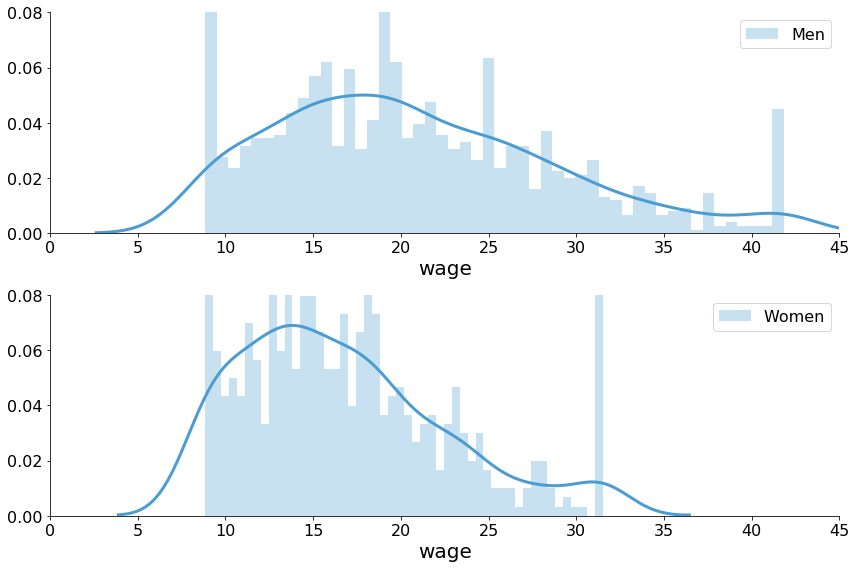

In [19]:
# Seaborn
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.distplot(ME['wage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=50, ax=ax[0])
sns.distplot(FE['wage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=50, ax=ax[1])

ax[0].legend(['Men'])
ax[1].legend(['Women']) 

ax[0].set_xlim([0,45])
ax[1].set_xlim([0,45])

ax[0].set_ylim([0,0.08])
ax[1].set_ylim([0,0.08])

plt.tight_layout()

In [20]:
fig.savefig('./figures/fig1_2_SOEP_wins.png', bbox_inches='tight', transparent=True)

## Estimation 

### Initial Conditions

In [21]:
λ_0 = 0.506
λ_M = 0.558
λ_F = 0.457

h_0 = 0.506
h_M = 0.558
h_F = 0.457

η_0 = 0.116
η_M = 0.108
η_F = 0.133

μ_0 = 3.433
μ_M = 3.456
μ_F = 3.454

σ_0 = 0.523
σ_M = 0.558
σ_F = 0.423

p_0 = 0.5
d_0 = 10

### Parameters without distributional assumptions

In [22]:
wstarM = min(ME['wage'])
wstarF = min(FE['wage'])

α = 0.5

### Accepted Wage Distribution as in 13, Log Normal as transformation from Normal

In [23]:
def lognormpdf(x: np.array, μ: float, σ: float):
    """
    Calculates lognormal pdf without stats packages
    """
    
    denom = x * σ * np.sqrt(2*pi)
    exp_num = -(np.log(x)-μ)**2
    exp_denom = 2 * σ * σ
    num = np.exp(exp_num/exp_denom)
    
    return num/denom

In [24]:
def lognormsf(x: np.array, μ: float, σ: float):
    """
    Calculated lognormal cdf with scipy.stats normal cdf
    """
    
    lnx = np.log(x)
    num = lnx - μ
    denom = σ
    
    return 1-stats.norm.cdf(num/denom)

In [25]:
def dens_accepted(wage: np.array, α: float, μ: float, σ: float, wstar: float):
    """
    Calculates the density of accepted wages using the lognormal distribution (end of eq 13)
    """
    
    pdf_in = (wage - (1-α)*wstar)/α
    sf_in = wstar
    
    num = lognormpdf(pdf_in, μ, σ) 
    denom = lognormsf(sf_in, μ, σ)
    
    return num / (α * denom)

In [26]:
def dens_accepted_prej(wage: np.array, α: float, μ: float, σ: float, wstar: float, d: float):
    """
    Calculates the density of accepted wages when prejudice is present using the lognormal distribution (end of eq 13)
    """
    
    pdf_in = (wage + α*d - (1-α)*wstar)/α
    sf_in = wstar+d
    
    num = lognormpdf(pdf_in, μ, σ) 
    denom = lognormsf(sf_in, μ, σ)    
    
    return num / (α * denom)

In [27]:
def hazardM(λ: float, wstar: float, α: float, μ: float, σ: float):
    """
    Estimates hazard rate for men (eq 10 of the paper)
    """

    mult = lognormsf(wstar, μ, σ)
    
    return λ * mult

In [28]:
def hazardF(λ: float, wstar: float, α: float, μ: float, σ: float, p: float, d: float):
    """
    Estimates hazard rate for women (eq 10 of the paper)
    """
    
    sf_in1 = wstar
    sf_in2 = wstar+d
    
    mult = (1-p)*lognormsf(sf_in1, μ, σ) + p*lognormsf(sf_in2, μ, σ)
    
    return λ * mult

### Test Statistics

In [29]:
def teststats (hess_inv: np.ndarray, lnL: float, nparams: int):
    """
    Calculates the standard errors and p value from the LR tests
    """
    se = np.sqrt(np.diag(hess_inv))
    
    loglik_H0 = lnL_6
    
    LR = 2 * (lnL - loglik_H0)
    pval = stats.chi2.pdf(LR, nparams)
    
    ts = se.tolist()
    ts.append(lnL)
    ts.append(pval)
    
    return ts

#### Estimation 6

In [30]:
def loglik_6( params: list ):
    """
    Calculates log likelihood with prejudice and productivity differences (Estimation 6)
    
    Parameters to estimate: λM, λF, ηM, ηF, μM, σM, μF, σF, d, p
    """
    
    λM = np.exp(params[0])
    λF = np.exp(params[1])
    ηM = np.exp(params[2])
    ηF = np.exp(params[3])
    μM = params[4]
    σM = np.exp(params[5])
    μF = params[6]
    σF = np.exp(params[7])
    d  = np.exp(params[8])
    p  = np.exp(params[9])
    
    
    # Men's equations 
    hM = hazardM(λM, wstarM, α, μM, σM)
    
    a = M['dur'].count() * np.log(hM/(hM+ηM))
    b = MU['dur'].count() * np.log(ηM)
    c = - hM * np.sum(MU.values[:,0])
    e = np.sum( np.log( (1/α) * dens_accepted( ME['wage'], α, μM, σM, wstarM) ) )  

    
    # Women's equations
    hF = hazardF(λF, wstarF, α, μF, σF, p, d)
    
    f = F['dur'].count() * np.log(hF/(hF+ηF))
    g = FU['dur'].count() * np.log(ηF)
    h = - hF * np.sum(FU.values[:,0])
    
    y = ((1-p)/α) * dens_accepted( FE['wage'], α, μF, σF, wstarF)
    z = (p/α) * dens_accepted_prej( FE['wage'], α, μF, σF, wstarF, d)
      
    i = np.sum( np.log( y + z ) )
    
    
    return -(a + b + c + e + f + g + h + i)

In [31]:
# Check on log-likelihood

param6 = [λ_M, λ_F, η_M, η_F, μ_M, σ_M, μ_F, σ_F, d_0, p_0]

b6_0 = np.log(param6[0])
b6_1 = np.log(param6[1])
b6_2 = np.log(param6[2])
b6_3 = np.log(param6[3])
b6_4 = param6[4]
b6_5 = np.log(param6[5])
b6_6 = param6[6]
b6_7 = np.log(param6[7])
b6_8 = np.log(param6[8])
b6_9 = np.log(1)

init6 = [b6_0, b6_1, b6_2, b6_3, b6_4, b6_5, b6_6, b6_7, b6_8, b6_9]

print(loglik_6(init6))

6506.912627052691


In [32]:
print(init6)

[-0.583396316600826, -0.7830718880879323, -2.2256240518579173, -2.017406150760383, 3.456, -0.583396316600826, 3.454, -0.8603830999358592, 2.302585092994046, 0.0]


In [33]:
est_6 = minimize(loglik_6, init6)

est_6

      fun: 6444.98294159042
 hess_inv: array([[ 2.10825229e-03,  1.13593787e-03,  1.51969448e-03,
         8.50273946e-04,  3.01518607e-05, -2.10867985e-04,
        -8.00421675e-04,  9.31828556e-04,  2.93482623e-03,
         1.06747323e-03],
       [ 1.13593787e-03,  1.03740582e-02,  2.16090111e-03,
         4.82945218e-04, -9.81519681e-05, -2.26975899e-04,
        -7.14187149e-04,  9.39291887e-04,  1.19063317e-02,
         1.01280430e-02],
       [ 1.51969448e-03,  2.16090111e-03,  5.99822847e-03,
        -9.66734267e-04,  3.77535218e-05, -3.71836372e-04,
        -1.67244102e-03,  1.64993388e-03,  7.75160275e-03,
         3.48448741e-03],
       [ 8.50273946e-04,  4.82945218e-04, -9.66734267e-04,
         3.94856890e-03, -2.32167373e-04,  2.85490494e-05,
         2.88109786e-04, -9.01902134e-04,  1.72113378e-04,
        -2.04783372e-03],
       [ 3.01518607e-05, -9.81519681e-05,  3.77535218e-05,
        -2.32167373e-04,  3.04900724e-04, -1.10576226e-04,
         1.21591481e-05, -2.419

In [34]:
# Coefficients

λM_6 = np.exp(est_6.x[0])
λF_6 = np.exp(est_6.x[1])
ηM_6 = np.exp(est_6.x[2])
ηF_6 = np.exp(est_6.x[3])
μM_6 = est_6.x[4]
σM_6 = np.exp(est_6.x[5])
μF_6 = est_6.x[6]
σF_6 = np.exp(est_6.x[7])
d_6  = np.exp(est_6.x[8])
p_6  = np.exp(est_6.x[9])

coeff_6 = [λM_6, λF_6, ηM_6, ηF_6, μM_6, σM_6, μF_6, σF_6, d_6, p_6]

print(coeff_6)

[0.570322855400464, 0.7977165869681949, 0.10801342979357667, 0.133977390091662, 3.3291909437902643, 0.5681343646476833, 3.34903109554237, 0.3392180680255432, 60.04607801666561, 0.42783083817621903]


In [35]:
lnL_6 = est_6.fun

print(lnL_6)

6444.98294159042


In [36]:
ts_6 = teststats(est_6.hess_inv, lnL_6, 10)

print(ts_6)

[0.045915708486873534, 0.10185312092920687, 0.07744823088548224, 0.06283763921179684, 0.01746140670008499, 0.024963558284158312, 0.02474419947104088, 0.04472815960700245, 0.15257003821817428, 0.1249896951899015, 6444.98294159042, 0.0]


#### Estimation 3

In [37]:
def loglik_3( params: list ):
    """
    Calculates log likelihood with prejudice and productivity differences 
    
    Estimation 3 (η and h not gender specific)
    
    Parameters to estimate: λ, η, μM, σM, μF, σF, d, p
    """
    
    λM = np.exp(params[0]) #same lambda
    λF = np.exp(params[0]) #same lambda
    η = np.exp(params[1]) #same eta
    μM = params[2]
    σM = np.exp(params[3])
    μF = params[4]
    σF = np.exp(params[5])
    d = np.exp(params[6])
    p = np.exp(params[7])
    
    
    # Men's equations
    hM = hazardM(λM, wstarM, α, μM, σM)
    
    a = M['dur'].count() * np.log(hM/(hM+η))
    b = MU['dur'].count() * np.log(η)
    c = - hM * np.sum(MU.values[:,0])
    e = np.sum( np.log( (1/α) * dens_accepted( ME['wage'], α, μM, σM, wstarM) ) )
    
    
    # Women's equations
    hF = hazardF(λF, wstarF, α, μM, σM, p, d)
    
    f = F['dur'].count() * np.log(hF/(hF+η))
    g = FU['dur'].count() * np.log(η)
    i = - hF * np.sum(FU.values[:,0])
    
    y = ((1-p)/α) * dens_accepted( FE['wage'], α, μF, σF, wstarF)
    z = (p/α) * dens_accepted_prej( FE['wage'], α, μF, σF, wstarF, d)

    j = np.sum( np.log( y + z ) )
    
    
    return -(a + b + c + e + f + g + i + j)

In [38]:
# Check on log-likelihood

param3 = [λ_0, η_0, μ_M, σ_M, μ_F, σ_F, d_0, p_0]

b3_0 = np.log(param3[0])
b3_1 = np.log(param3[1])
b3_2 = param3[2]
b3_3 = np.log(param3[3])
b3_4 = param3[4]
b3_5 = np.log(param3[5])
b3_6 = np.log(param3[6])
b3_7 = np.log(1)

init3 = [b3_0, b3_1, b3_2, b3_3, b3_4, b3_5, b3_6, b3_7]

print(loglik_3(init3))

6510.052927415925


In [39]:
est_3 = minimize(loglik_3, init3)

est_3

      fun: 6448.114262021706
 hess_inv: array([[ 6.77039997e-03,  7.65326858e-03,  1.28840870e-04,
        -2.73945713e-04,  2.46553501e-03,  3.90501450e-04,
        -1.23704174e-02,  1.77768998e-02],
       [ 7.65326858e-03,  1.06693401e-02,  2.31735460e-04,
        -6.35856223e-04,  3.34463037e-03,  4.47733137e-04,
        -1.56825341e-02,  2.19601733e-02],
       [ 1.28840870e-04,  2.31735460e-04,  3.54144421e-04,
        -1.43185607e-04,  1.37056255e-04,  5.05738441e-05,
        -9.18758294e-04,  1.06947559e-03],
       [-2.73945713e-04, -6.35856223e-04, -1.43185607e-04,
         6.54707602e-04, -2.14165577e-04,  7.49663174e-05,
         1.50266967e-03, -1.63129441e-03],
       [ 2.46553501e-03,  3.34463037e-03,  1.37056255e-04,
        -2.14165577e-04,  1.72765581e-03, -3.73029929e-04,
        -6.41270972e-03,  8.54866058e-03],
       [ 3.90501450e-04,  4.47733137e-04,  5.05738441e-05,
         7.49663174e-05, -3.73029929e-04,  1.95674794e-03,
         3.96713724e-04,  1.67777416e

In [40]:
# Coefficients

λ_3 = np.exp(est_3.x[0])
η_3 = np.exp(est_3.x[1])
μM_3 = est_3.x[2]
σM_3 = np.exp(est_3.x[3])
μF_3 = est_3.x[4]
σF_3 = np.exp(est_3.x[5])
d_3 = np.exp(est_3.x[6])
p_3 = np.exp(est_3.x[7])

coeff_3 = [λ_3, η_3, μM_3, σM_3, μF_3, σF_3, d_3, p_3]

print(coeff_3)

[0.623601064484499, 0.11879274082357513, 3.33056048098153, 0.5689414932272288, 3.337676467775946, 0.33867036732413863, 39.37355011566521, 0.3986806443856615]


In [41]:
lnL_3 = est_3.fun

print(lnL_3)

6448.114262021706


In [42]:
ts_3 = teststats(est_3.hess_inv, lnL_3, 8)

print(ts_3)

[0.08228244021277957, 0.10329249785482957, 0.018818725264126125, 0.025587254673227717, 0.04156507923557317, 0.04423514367207034, 0.1690569142085072, 0.24344042264690233, 6448.114262021706, 0.11170847027562783]


#### Estimation 5

In [43]:
def loglik_5( params: list ):
    """
    Calculates log likelihood with prejudice, no productivity differences (estimation 5). 
    
    Parameters to estimate: λM, λF, μ, σ, p, d
    """

    λM = np.exp(params[0])
    λF = np.exp(params[1])
    ηM = np.exp(params[2])
    ηF = np.exp(params[3])
    μ = params[4]
    σ = np.exp(params[5])
    d = np.exp(params[6])
    p = np.exp(params[7])
    
    
    # Men's equations 
    hM = hazardM(λM, wstarM, α, μ, σ)
    
    a = M['dur'].count() * np.log(hM/(hM+ηM))
    b = MU['dur'].count() * np.log(ηM)
    c = - hM * np.sum(MU.values[:,0])
    e = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μ, σ, wstarM) ) )
    
    
    # Women's equations
    hF = hazardF(λF, wstarF, α, μ, σ, p, d)
    
    f = F['dur'].count() * np.log(hF/(hF+ηF))
    g = FU['dur'].count() * np.log(ηF)
    h = - hF * np.sum(FU.values[:,0])
    
    y = ((1-p)/α) * dens_accepted(FE['wage'], α, μ, σ, wstarF)
    z = (p/α) * dens_accepted_prej(FE['wage'], α, μ, σ, wstarF, d)

    i = np.sum( np.log( y + z ) )
    
    
    return -(a + b + c + e + f + g + h + i)

In [44]:
# Check on log-likelihood

param5 = [λ_M, λ_F, η_M, η_F, μ_0, σ_0, d_0, p_0]

b5_0 = np.log(param6[0])
b5_1 = np.log(param6[1])
b5_2 = np.log(param6[2])
b5_3 = np.log(param6[3])
# b5_4 = np.log(param6[4])
b5_4 = param6[4]
b5_5 = np.log(param6[5])
b5_6 = np.log(param6[6])
b5_7 = np.log(1)

init5 = [b5_0, b5_1, b5_2, b5_3, b5_4, b5_5, b5_6, b5_7]

print(loglik_5(init5))

6605.594288593054


In [45]:
est_5 = minimize(loglik_5, init5)

est_5

/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log


      fun: 6487.694113044838
 hess_inv: array([[ 0.00428381,  0.0036268 ,  0.006412  , -0.00153612, -0.00021399,
         0.00011901,  0.00658479, -0.00096926],
       [ 0.0036268 ,  0.0105274 ,  0.00378286,  0.00412961, -0.00045455,
        -0.00030309,  0.01773313, -0.00964753],
       [ 0.006412  ,  0.00378286,  0.02592033, -0.00742271, -0.00142015,
         0.00093894,  0.00450056,  0.00195077],
       [-0.00153612,  0.00412961, -0.00742271,  0.00967558,  0.00053649,
        -0.00098269,  0.01027377, -0.00825774],
       [-0.00021399, -0.00045455, -0.00142015,  0.00053649,  0.00039138,
        -0.00020025, -0.00052164,  0.0003705 ],
       [ 0.00011901, -0.00030309,  0.00093894, -0.00098269, -0.00020025,
         0.00045005, -0.00028746,  0.00022463],
       [ 0.00658479,  0.01773313,  0.00450056,  0.01027377, -0.00052164,
        -0.00028746,  0.03438975, -0.01865861],
       [-0.00096926, -0.00964753,  0.00195077, -0.00825774,  0.0003705 ,
         0.00022463, -0.01865861,  0.013

In [46]:
# Coefficients

λM_5 = np.exp(est_5.x[0])
λF_5 = np.exp(est_5.x[1])
ηM_5 = np.exp(est_5.x[2])
ηF_5 = np.exp(est_5.x[3])
μ_5 = est_5.x[4]
σ_5 = np.exp(est_5.x[5])
d_5 = np.exp(est_5.x[6])
p_5 = np.exp(est_5.x[7])

coeff_5 = [λM_5, λF_5, ηM_5, ηF_5, μ_5, σ_5, d_5, p_5]

print(coeff_5)

[0.5667353390601806, 0.7484789973449865, 0.1080135097992883, 0.1339773074269028, 3.3168060102218173, 0.5260267757412171, 18.091637325348877, 0.7988486387194483]


In [47]:
lnL_5 = est_5.fun

print(lnL_5)

6487.694113044838


In [48]:
ts_5 = teststats(est_5.hess_inv, lnL_5, 8)

print(ts_5)

[0.06545081962688908, 0.10260309898838571, 0.1609979304677244, 0.09836450420829565, 0.019783369361929325, 0.02121432033335354, 0.1854447244572699, 0.11562164499373997, 6487.694113044838, 1.833230715160835e-15]


#### Estimation 2

In [49]:
def loglik_2( params: list ):
    """
    Calculates log likelihood with prejudice, no productivity differences (estimation 2).
    
    Parameters to estimate: λ, μ, σ, p, d
    """
    
    λM = np.exp(params[0])
    λF = np.exp(params[0])
    η = np.exp(params[1])
    μ = params[2]
    σ = np.exp(params[3])
    d = np.exp(params[4])
    p = np.exp(params[5])

    
    # Men's equations 
    hM = hazardM(λM, wstarM, α, μ, σ)
    
    a = M['dur'].count() * np.log(hM/(hM+η))
    b = MU['dur'].count() * np.log(η)
    c = - hM * np.sum(MU.values[:,0])
    e = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μ, σ, wstarM) ) )
    
    
    # Women's equations
    hF = hazardF(λF, wstarF, α, μ, σ, p, d)
    
    f = F['dur'].count() * np.log(hF/(hF+η))
    g = FU['dur'].count() * np.log(η)
    i = - hF * np.sum(FU.values[:,0])
    
    y = ((1-p)/α) * dens_accepted(FE['wage'], α, μ, σ, wstarF)
    z = (p/α) * dens_accepted_prej(FE['wage'], α, μ, σ, wstarF, d)

    j = np.sum( np.log( y + z ) )
    
    
    return -(a + b + c + e + f + g + i + j)

In [50]:
# Check on log-likelihood

param2 = [λ_0, η_0, μ_0, σ_0, d_0, p_0]

b2_0 = np.log(param2[0])
b2_1 = np.log(param2[1])
b2_2 = param2[2]
b2_3 = np.log(param2[3])
b2_4 = np.log(param2[4])
b2_5 = np.log(1)

init2 = [b2_0, b2_1, b2_2, b2_3, b2_4, b2_5]

print(loglik_2(init2))

6530.313131313066


In [51]:
est_2 = minimize(loglik_2, init2)

est_2

      fun: 6489.271791152495
 hess_inv: array([[ 7.52606924e-03,  9.49397312e-03, -8.91154678e-05,
         1.05523543e-03,  6.62350319e-03, -3.02067141e-03],
       [ 9.49397312e-03,  1.52102831e-02,  1.73712380e-04,
         1.19691748e-03,  8.46628149e-03, -3.17596594e-03],
       [-8.91154678e-05,  1.73712380e-04,  1.90487488e-04,
        -1.21276980e-04, -2.46620367e-05, -1.60231113e-04],
       [ 1.05523543e-03,  1.19691748e-03, -1.21276980e-04,
         5.64807461e-04,  1.32355251e-03, -4.63034172e-04],
       [ 6.62350319e-03,  8.46628149e-03, -2.46620367e-05,
         1.32355251e-03,  9.91679759e-03, -4.49772505e-03],
       [-3.02067141e-03, -3.17596594e-03, -1.60231113e-04,
        -4.63034172e-04, -4.49772505e-03,  3.14836509e-03]])
      jac: array([-6.10351562e-05,  0.00000000e+00, -1.83105469e-04, -6.10351562e-05,
       -6.10351562e-05, -6.10351562e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 185
      nit: 15
     njev: 23

In [52]:
# Coefficients

λ_2 = np.exp(est_2.x[0])
η_2 = np.exp(est_2.x[1])
μ_2 = est_2.x[2]
σ_2 = np.exp(est_2.x[3])
d_2 = np.exp(est_2.x[4])
p_2 = np.exp(est_2.x[5])

coeff_2 = [λ_2, η_2, μ_2, σ_2, d_2, p_2]

print(coeff_2)

[0.601041031650277, 0.11891203498782597, 3.3166125428284694, 0.5279188715056954, 12.544348655648596, 0.9180138666179612]


In [53]:
lnL_2 = est_2.fun

print(lnL_2)

6489.271791152495


In [54]:
ts_2 = teststats(est_2.hess_inv, lnL_2, 6)

print(ts_2)

[0.08675292065555171, 0.12332997642169187, 0.013801720469121615, 0.023765678206385178, 0.09958311899609794, 0.05611029399336313, 6489.271791152495, 2.858418622359933e-17]


#### Estimation 4

In [55]:
def loglik_4( params: list ):
    """
    Calculates log likelihood with productivity differences, no prejudice (estimation 4).
    
    Parameters to estimate: λM, λF, μM, σM, μF, σF
    """

    λM = np.exp(params[0])
    λF = np.exp(params[1])
    ηM = np.exp(params[2])
    ηF = np.exp(params[3])
    μM = params[4]
    σM = np.exp(params[5])
    μF = params[6]
    σF = np.exp(params[7])
    d = 0
    p = 0

    
    # Men's equations 
    hM = hazardM(λM, wstarM, α, μM, σM)
    
    a = M['dur'].count() * np.log(hM/(hM+ηM))
    b = MU['dur'].count() * np.log(ηM)
    c = - hM * np.sum(MU.values[:,0])
    e = np.sum( np.log( (1/α) * dens_accepted( ME['wage'], α, μM, σM, wstarM) ) )
    
    # Women's equations
    hF = hazardF(λF, wstarF, α, μF, σF, p, d)
    
    f = F['dur'].count() * np.log(hF/(hF+ηF))
    g = FU['dur'].count() * np.log(ηF)
    i = - hF * np.sum(FU.values[:,0])
    
    y = (1/α) * dens_accepted( FE['wage'], α, μF, σF, wstarF)

    j = np.sum( np.log( y ) )

    return -(a + b + c + e + f + g + i + j)

In [56]:
# Check on log-likelihood

param4 = [λ_M, λ_F, η_M, η_F, μ_M, σ_M, μ_F, σ_F]

b4_0 = np.log(param4[0])
b4_1 = np.log(param4[1])
b4_2 = np.log(param4[2])
b4_3 = np.log(param4[3])
b4_4 = param4[4]
b4_5 = np.log(param4[5])
b4_6 = param4[6]
b4_7 = np.log(param4[7])

init4 = [b4_0, b4_1, b4_2, b4_3, b4_4, b4_5, b4_6, b4_7]

print(loglik_4(init4))

6820.350277466316


In [57]:
print(init4)

[-0.583396316600826, -0.7830718880879323, -2.2256240518579173, -2.017406150760383, 3.456, -0.583396316600826, 3.454, -0.8603830999358592]


In [58]:
est_4 = minimize(loglik_4, init4)

est_4

      fun: 6484.239598515669
 hess_inv: array([[ 5.00337811e-03, -7.68533824e-04,  5.15132280e-03,
        -7.96400942e-04, -7.16248704e-04,  1.12167268e-03,
         1.53059323e-03,  4.24189589e-04],
       [-7.68533824e-04,  6.48840223e-03, -1.10323006e-03,
         6.76741034e-03,  9.20349656e-04, -1.37839936e-03,
        -2.33587261e-03,  6.68969053e-05],
       [ 5.15132280e-03, -1.10323006e-03,  1.05128115e-02,
        -7.01977229e-04, -1.25116692e-03,  1.97115985e-03,
         2.87171386e-03,  7.41146566e-04],
       [-7.96400942e-04,  6.76741034e-03, -7.01977229e-04,
         1.31580456e-02,  1.61031050e-03, -2.43675143e-03,
        -3.67752070e-03, -5.99370619e-04],
       [-7.16248704e-04,  9.20349656e-04, -1.25116692e-03,
         1.61031050e-03,  6.87977069e-04, -6.30814560e-04,
        -8.10310841e-04, -2.89601396e-04],
       [ 1.12167268e-03, -1.37839936e-03,  1.97115985e-03,
        -2.43675143e-03, -6.30814560e-04,  1.34160986e-03,
         1.16712313e-03,  3.41805813e

In [59]:
# Coefficients

λM_4 = np.exp(est_4.x[0])
λF_4 = np.exp(est_4.x[1])
ηM_4 = np.exp(est_4.x[2])
ηF_4 = np.exp(est_4.x[3])
μM_4 = est_4.x[4]
σM_4 = np.exp(est_4.x[5])
μF_4 = est_4.x[6]
σF_4 = np.exp(est_4.x[7])

coeff_4 = [λM_4, λF_4, ηM_4, ηF_4, μM_4, σM_4, μF_4, σF_4]

print(coeff_4)

[0.5703228210687591, 0.49732720889694876, 0.10801344404473649, 0.13397736601812374, 3.3291909535505386, 0.5681343266554968, 2.9883959282992834, 0.574019127119415]


In [60]:
lnL_4 = est_4.fun

print(lnL_4)

6484.239598515669


In [61]:
ts_4 = teststats(est_4.hess_inv, lnL_4, 8)

print(ts_4)

[0.0707345609158121, 0.08055061903086821, 0.10253200242074124, 0.11470852469503239, 0.026229316978795738, 0.03662799291141939, 0.04724728738215924, 0.04029229140975689, 6484.239598515669, 4.504112309348596e-14]


#### Estimation 1

In [62]:
def loglik_1( params: list ):
    """
    Calculates log likelihood with productivity differences, no prejudice (estimation 1).
    
    Parameters to estimate: λ, η, μM, σM, μF, σF
    """

    λM = np.exp(params[0]) #same lambda
    λF = np.exp(params[0]) #same lambda
    η = np.exp(params[1]) #same eta
    μM = params[2]
    σM = np.exp(params[3])
    μF = params[4]
    σF = np.exp(params[5])
    d = 0
    p = 0
    
    
    # Men's equations 
    hM = hazardM(λM, wstarM, α, μM, σM)
    
    a = M['dur'].count() * np.log(hM/(hM+η))
    b = MU['dur'].count() * np.log(η)
    c = - hM * np.sum(MU.values[:,0])
    e = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μM, σM, wstarM) ) )
    
    # Women's equations
    hF = hazardF(λM, wstarF, α, μF, σF, p, d)
    
    f = F['dur'].count() * np.log(hF/(hF+η))
    g = FU['dur'].count() * np.log(η)
    i = - hF * np.sum(FU.values[:,0])
    
    y = (1/α) * dens_accepted(FE['wage'], α, μF, σF, wstarF)
    
    j = np.sum( np.log( y ) )
    
    
    return -(a + b + c + e + f + g + i + j)

In [63]:
# Check on log-likelihood

param1 = [λ_0, η_0, μ_M, σ_M, μ_F, σ_F]

b1_0 = np.log(param1[0])
b1_1 = np.log(param1[1])
b1_2 = param1[2]
b1_3 = np.log(param1[3])
b1_4 = param1[4]
b1_5 = np.log(param1[5])

init1 = [b1_0, b1_1, b1_2, b1_3, b1_4, b1_5]

print(loglik_1(init1))

6829.948984512112


In [64]:
est_1 = minimize(loglik_1, init1)

est_1

      fun: 6490.084478938475
 hess_inv: array([[ 8.10314700e-04,  4.15776406e-04, -5.26228659e-05,
        -1.24322960e-05, -5.45696821e-12, -4.28804934e-05],
       [ 4.15776406e-04,  1.46516170e-02,  1.27424390e-05,
        -4.11178139e-04, -5.09317033e-11, -7.14487467e-05],
       [-5.26228659e-05,  1.27424390e-05,  3.40230283e-04,
        -1.17827693e-04,  0.00000000e+00,  3.40656723e-05],
       [-1.24322960e-05, -4.11178139e-04, -1.17827693e-04,
         6.61180112e-04,  1.81898940e-12, -5.44953322e-05],
       [-5.45696821e-12, -5.09317033e-11,  0.00000000e+00,
         1.81898940e-12,  1.45519152e-11, -9.09494702e-12],
       [-4.28804934e-05, -7.14487467e-05,  3.40656723e-05,
        -5.44953322e-05, -9.09494702e-12,  5.17697900e-04]])
      jac: array([0.00000000e+00, 6.10351562e-05, 0.00000000e+00, 0.00000000e+00,
       6.10351562e-05, 6.10351562e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 441
      nit: 19
     njev: 55
   st

In [65]:
# Coefficients

λ_1 = np.exp(est_1.x[0])
η_1 = np.exp(est_1.x[1])
μM_1 = est_1.x[2]
σM_1 = np.exp(est_1.x[3])
μF_1 = est_1.x[4]
σF_1 = np.exp(est_1.x[5])

coeff_1 = [λ_1, η_1, μM_1, σM_1, μF_1, σF_1]

print(coeff_1)

[0.5368369524884239, 0.11738172918932115, 3.3308996500264763, 0.5663574317819295, 2.968602270203934, 0.5893524864243078]


In [66]:
lnL_1 = est_1.fun

print(lnL_1)

6490.084478938475


In [67]:
ts_1 = teststats(est_1.hess_inv, lnL_1, 6)

print(ts_1)

[0.028466027127563603, 0.12104386397826641, 0.01844533229531442, 0.02571342279316481, 3.814697265625e-06, 0.022752975636319003, 6490.084478938475, 1.3151458061166822e-17]


### Output to Latex

In [68]:
# Make coeff and ts arrays the same length
def pad(coeff: np.array):
    while len(coeff) != 12:
        coeff.append(None)
    return coeff

In [69]:
# Pad all vectors for dataframe. 
pad(coeff_1)
pad(ts_1)
pad(coeff_2)
pad(ts_2)
pad(coeff_3)
pad(ts_3)
pad(coeff_4)
pad(ts_4)
pad(coeff_5)
pad(ts_5)
pad(coeff_6)
pad(ts_6)

[0.045915708486873534,
 0.10185312092920687,
 0.07744823088548224,
 0.06283763921179684,
 0.01746140670008499,
 0.024963558284158312,
 0.02474419947104088,
 0.04472815960700245,
 0.15257003821817428,
 0.1249896951899015,
 6444.98294159042,
 0.0]

In [70]:
out = pd.DataFrame({
    '(1)': coeff_1,
    'se1': ts_1,
    '(2)': coeff_2,
    'se2': ts_2,
    '(3)': coeff_3,
    'se3': ts_3,
    '(4)': coeff_4,
    'se4': ts_4,
    '(5)': coeff_5,
    'se5': ts_5,
    '(6)': coeff_6,
    'se6': ts_6
})

In [71]:
np.savetxt('./output_SOEP.csv', out, fmt='%1.4f', delimiter=',')

### Predicted Values

In [72]:
def E(μ: float, σ: float):
    """
    Calculates predicted values of Expected Productivity E(x) from Table 3 
    """
    
    exp_in = μ + .5*σ*σ
    
    return np.exp(exp_in)

In [73]:
def V(μ: float, σ: float):
    """
    Calculates predicted values of Variance of Expected Productivity V(x) from Table 3 
    """
    
    exp_in1 = 2*μ + 2*σ*σ
    exp_in2 = 2*μ + σ*σ
    
    return np.exp(exp_in1) - np.exp(exp_in2)

In [74]:
def int_in(x:np.array, μ: float, σ: float):
    """
    Function for integrand
    """
    
    return x * lognormpdf(x, μ, σ)

In [75]:
def Ew_M(x: np.array, α: float, wstar: float, μ: float, σ: float):
    """
    Calculated predicted values of Expected Wage given Employed for Men E(w|E) from Table 3
    """
    
    mult1 = α/lognormsf(wstar,μ,σ)
    integral = integrate.quad(lambda x: int_in(x, μ, σ), 0, wstar)
    mult2 = E(μ,σ) - integral[0]
    
    add = (1-α)*wstar
    
    return (mult1 * mult2) + add

In [76]:
def Ew_F(x: np.array, α: float, wstar: float, μ: float, σ: float, p: float, d: float):
    """
    Calculated predicted values of Expected Wage given Employed for Women E(w|E) from Table 3
    """
    
    n_mult1 = α/lognormsf(wstar,μ,σ)
    
    n_integral = integrate.quad(lambda x:int_in(x, μ, σ), 0, wstar)
    n_mult2 = E(μ,σ) - n_integral[0]
    
    n_add = (1-α)*wstar
    
    nonprej = (1-p) * ((n_mult1 * n_mult2) + n_add)
    
    
    p_mult1 = α/lognormsf(wstar+d,μ,σ)
    
    p_integral = integrate.quad(lambda x: int_in(x, μ, σ), 0, wstar+d)
    p_mult2 = E(μ,σ) - p_integral[0]
    
    p_add = (1-α)*wstar - α*d
    
    prej = p * ((p_mult1 * p_mult2) + p_add)
    
    return nonprej + prej

In [77]:
def pred_hazardM(η: float, λ: float, wstar: float, μ: float, σ: float):
    """
    Calculates predicted hazard rate for men to then find predicted values for Unemployed in Table 3
    """
    
    sf = lognormsf(wstar,μ, σ)
    
    return η + (λ*sf)

In [78]:
def uM(η: float, λ: float, wstar: float, μ: float, σ: float):
    """
    Calculated predicted proportion of unemployed men for Table 3
    """
    
    hM = pred_hazardM(η,λ,wstar,μ,σ)
    
    return η / hM

In [79]:
def Et_M(η: float, λ: float, wstar: float, μ: float, σ: float):
    """
    Calculated predicted duration of unemployment for unemployed men for Table 3
    """
    
    hM = pred_hazardM(η,λ,wstar,μ,σ)
    
    return 1 / hM

In [80]:
def pred_hazardF(η: float, λ: float, wstar: float, μ: float, σ: float, p: float, d: float):
    """
    Calculates predicted hazard rate for women to then find predicted values for Unemployed in Table 3
    """
    
    sf1 = lognormsf(wstar,μ, σ)
    sf2 = lognormsf(wstar+d,μ, σ)
    
    mult = (1-p)*sf1 + p*sf2
    
    return η + (λ*mult)

In [81]:
def uF(η: float, λ: float, wstar: float, μ: float, σ: float, p:float, d: float):
    """
    Calculated predicted proportion of unemployed women for Table 3
    """
    
    hF = pred_hazardF(η,λ,wstar,μ,σ,p, d)
    
    return η / hF

In [82]:
def Et_F(η: float, λ: float, wstar: float, μ: float, σ: float, p:float, d: float):
    """
    Calculated predicted duration of unemployment for unemployed women for Table 3
    """
    
    hF = pred_hazardF(η,λ,wstar,μ,σ,p, d)
    
    return 1 / hF

In [83]:
def predicts(λM: float, ηM: float, λF: float, ηF: float, μM: float, σM: float, μF: float, σF: float, p: float, d: float):
    """
    Creates prediction vector based on values from estimations
    """
    EM = E(μM, σM)
    VM = V(μM, σM)
    EF = E(μF, σF)
    VF = V(μF, σF)
    EwM = Ew_M(ME['wage'], α, wstarM, μM, σM)
    EwF = Ew_F(FE['wage'], α, wstarF, μF, σF, p, d)
    u_M = uM(ηM, λM, wstarM, μM, σM)
    EtM = Et_M(ηM, λM_6, wstarM, μM, σM)
    u_F = uF(ηF, λF, wstarF, μF, σF, p, d)
    EtF = Et_F(ηF, λF, wstarF, μF, σF, p, d)

    pred = [EM, VM, EF, VF, EwM, EwF, u_M, EtM, u_F, EtF]

    return pred

#### Estimation 6

In [86]:
pred_6 = predicts(λM_6, ηM_6, λF_6, ηF_6, μM_6, σM_6, μF_6, σF_6, p_6, d_6)
print(pred_6)

[32.804945187491256, 409.97225221786175, 30.161477913611098, 110.94038212740531, 21.10267556764301, 16.68059548946747, 0.16216215141267343, 1.5013147135738565, 0.2263710807034079, 1.6896215141117004]


#### Estimation 3

In [87]:
pred_3 = predicts(λ_3, η_3, λ_3, η_3, μM_3, σM_3, μF_3, σF_3, p_3, d_3)
print(pred_3)

[32.864981287456665, 412.8437515012722, 29.815407098357838, 108.03890835655739, 21.13369430073461, 16.736292620556632, 0.1629572978265136, 1.4774353955545785, 0.23402631014888198, 1.9700388132002595]


#### Estimation 1

In [88]:
pred_1 = predicts(λ_1, η_1, λ_1, η_1, μM_1, σM_1, μF_1, σF_1, 0, 0)
print(pred_1)

[32.827941255210675, 407.5501236943285, 23.156382554507818, 222.68743424090815, 21.10797677840084, 16.804425376118743, 0.18256999458957435, 1.479895450837165, 0.19377093258102845, 1.6507759250036407]


#### Estimation 4

In [89]:
pred_4 = predicts(λM_4, ηM_4, λF_4, ηF_4, μM_4, σM_4, μF_4, σF_4, 0, 0)
print(pred_4)

[32.80494479959274, 409.9721783669918, 23.409569867345912, 213.87105597352866, 21.102675263214692, 16.832722665478315, 0.1621621764277735, 1.5013146713654721, 0.2263710400499049, 1.6896215142734083]


#### Estimation 2

In [90]:
pred_2 = predicts(λ_2, η_2, λ_2, η_2, μ_2, σ_2, μ_2, σ_2, p_2, d_2)
print(pred_2)

[31.688749428628928, 322.75113351521736, 31.688749428628928, 322.75113351521736, 20.456715719331697, 17.894223053802115, 0.1673466453818979, 1.4698654575937316, 0.2180892160377545, 1.8340382120285985]


### Estimation 5

In [91]:
pred_5 = predicts(λM_5, ηM_5, λF_5, ηF_5, μ_5, σ_5, μ_5, σ_5, p_5, d_5)
print(pred_2)

[31.688749428628928, 322.75113351521736, 31.688749428628928, 322.75113351521736, 20.456715719331697, 17.894223053802115, 0.1673466453818979, 1.4698654575937316, 0.2180892160377545, 1.8340382120285985]


### Output to Latex

In [92]:
out_pred = pd.DataFrame({
    '(1)': pred_1,
    '(2)': pred_2,
    '(3)': pred_3,
    '(4)': pred_4,
    '(5)': pred_5,
    '(6)': pred_6,
})

In [93]:
np.savetxt('./output_pred_SOEP.csv', out_pred, fmt='%1.3f', delimiter=',')